In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
drive_path = '/content/drive/MyDrive/Ai Intern/Data'
image_size = 150
for i in labels:
    folderPath = os.path.join(drive_path, 'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(drive_path, 'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:31<00:00,  2.34it/s]


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.3,random_state=42)


In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
def Show(model):
  y_true_test = np.argmax(y_test, axis=1)
  y_pred_test = np.argmax(model.predict(X_test), axis=1)

  heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [8]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8191
Epoch 1: val_accuracy improved from -inf to 0.86735, saving model to efficientnetB0.keras
83/83 [==============================] - 57s 187ms/step - loss: 0.4955 - accuracy: 0.8191 - val_loss: 0.4185 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9285
Epoch 2: val_accuracy did not improve from 0.86735
83/83 [==============================] - 11s 129ms/step - loss: 0.2073 - accuracy: 0.9285 - val_loss: 0.4793 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9614
Epoch 3: val_accuracy improved from 0.86735 to 0.90816, saving model to efficientnetB0.keras
83/83 [==============================] - 12s 146ms/step - loss: 0.1257 - accuracy: 0.9614 - val_loss: 0.3136 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 4/12
83/83 [==============================]

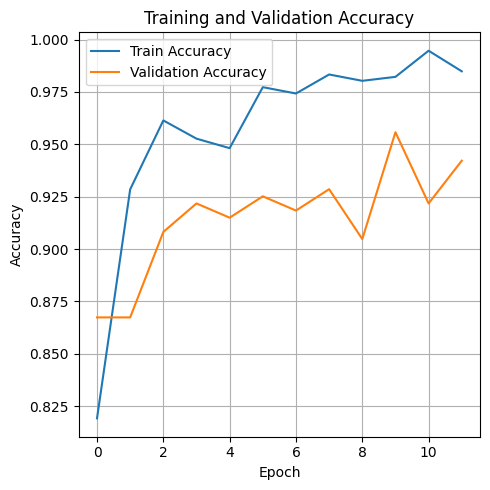

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 0s 11ms/step


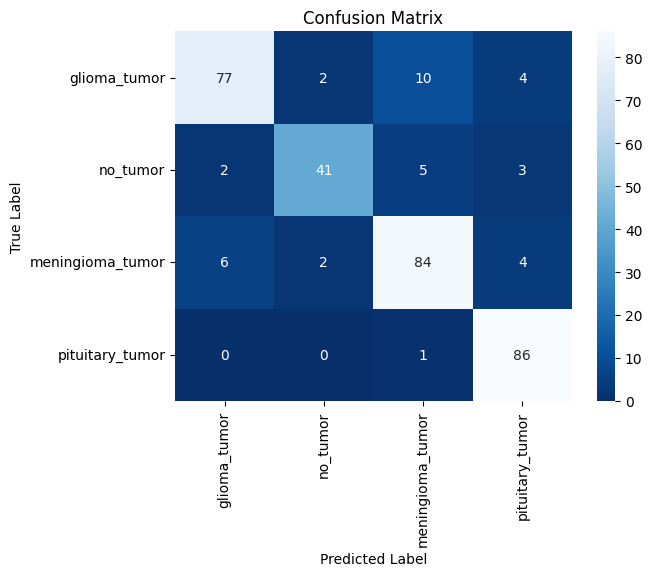

In [ ]:
Show(model)

In [ ]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97        93
           1       1.00      0.86      0.93        51
           2       0.91      0.95      0.93        96
           3       0.95      0.97      0.96        87

    accuracy                           0.95       327
   macro avg       0.96      0.94      0.95       327
weighted avg       0.95      0.95      0.95       327



1/1 [==============================] - 1s 1s/step
Predicted label: glioma_tumor 
Actual label: meningioma_tumor 
Confidence: 75.84%



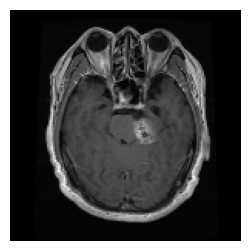

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


In [ ]:
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))


model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
tensorboard = TensorBoard(log_dir='logs')


checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 0.9144 - accuracy: 0.6897
Epoch 1: val_accuracy improved from -inf to 0.28912, saving model to efficientnetB0.keras
83/83 [==============================] - 108s 416ms/step - loss: 0.9144 - accuracy: 0.6897 - val_loss: 9439051.0000 - val_accuracy: 0.2891 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.7673
Epoch 2: val_accuracy improved from 0.28912 to 0.37415, saving model to efficientnetB0.keras
83/83 [==============================] - 30s 360ms/step - loss: 0.6302 - accuracy: 0.7673 - val_loss: 58.1863 - val_accuracy: 0.3741 - lr: 0.0010
Epoch 3/15
83/83 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8706
Epoch 3: val_accuracy improved from 0.37415 to 0.69048, saving model to efficientnetB0.keras
83/83 [==============================] - 30s 358ms/step - loss: 0.3716 - accuracy: 0.8706 - val_loss: 1.6859 - val_accuracy: 0.6905 - lr: 0.0010

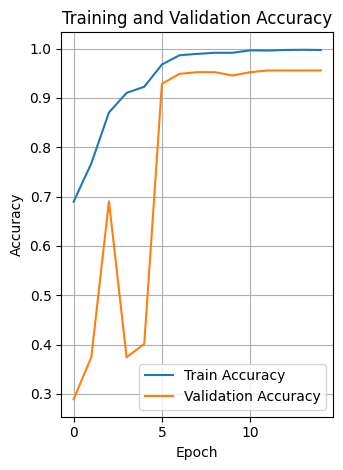

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 0s 11ms/step


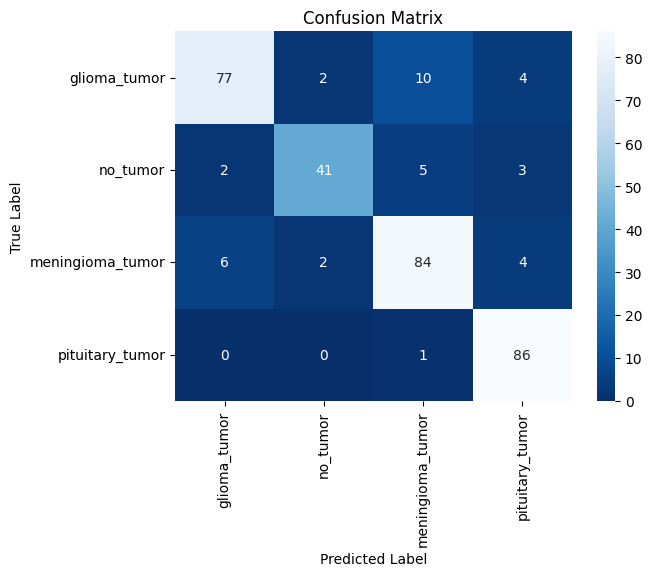

In [ ]:
Show(model)

In [ ]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.91      0.92      0.91        93
           1       0.94      0.90      0.92        51
           2       0.90      0.89      0.89        96
           3       0.96      0.98      0.97        87

    accuracy                           0.92       327
   macro avg       0.93      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



1/1 [==============================] - 1s 762ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 99.90%



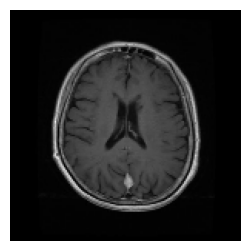

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))


predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'

In [ ]:
tensorboard = TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7510
Epoch 1: val_accuracy improved from -inf to 0.44898, saving model to efficientnetB0.keras
83/83 [==============================] - 56s 306ms/step - loss: 0.6857 - accuracy: 0.7510 - val_loss: 9.3078 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8941
Epoch 2: val_accuracy improved from 0.44898 to 0.74490, saving model to efficientnetB0.keras
83/83 [==============================] - 20s 238ms/step - loss: 0.3313 - accuracy: 0.8941 - val_loss: 1.6738 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9342
Epoch 3: val_accuracy improved from 0.74490 to 0.81293, saving model to efficientnetB0.keras
83/83 [==============================] - 20s 242ms/step - loss: 0.2228 - accuracy: 0.9342 - val_loss: 1.0749 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 4

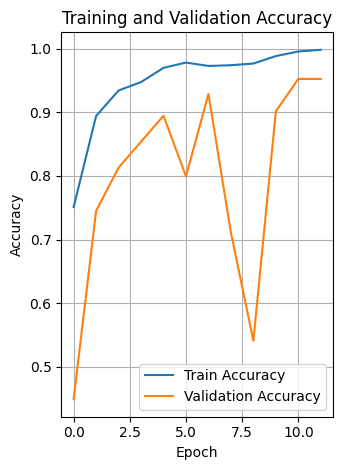

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 2s 169ms/step


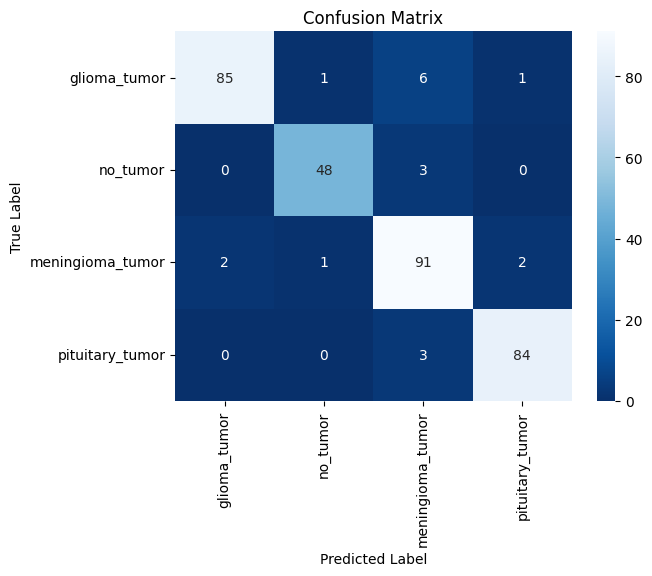

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.98      0.91      0.94        93
           1       0.96      0.94      0.95        51
           2       0.88      0.95      0.91        96
           3       0.97      0.97      0.97        87

    accuracy                           0.94       327
   macro avg       0.95      0.94      0.94       327
weighted avg       0.94      0.94      0.94       327



1/1 [==============================] - 1s 597ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



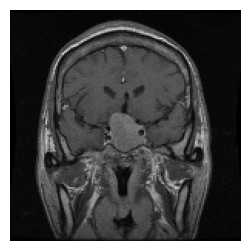

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

## My Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, batch_size=32, verbose=1)

Epoch 1/12
83/83 [==============================] - 6s 36ms/step - loss: 65.5878 - accuracy: 0.5463 - val_loss: 0.7142 - val_accuracy: 0.7109
Epoch 2/12
83/83 [==============================] - 3s 30ms/step - loss: 0.5263 - accuracy: 0.8104 - val_loss: 0.6776 - val_accuracy: 0.7993
Epoch 3/12
83/83 [==============================] - 3s 30ms/step - loss: 0.2648 - accuracy: 0.9126 - val_loss: 0.5521 - val_accuracy: 0.8469
Epoch 4/12
83/83 [==============================] - 2s 29ms/step - loss: 0.1452 - accuracy: 0.9572 - val_loss: 0.4695 - val_accuracy: 0.8707
Epoch 5/12
83/83 [==============================] - 2s 29ms/step - loss: 0.0668 - accuracy: 0.9841 - val_loss: 0.7139 - val_accuracy: 0.8707
Epoch 6/12
83/83 [==============================] - 2s 29ms/step - loss: 0.0717 - accuracy: 0.9826 - val_loss: 0.5357 - val_accuracy: 0.8639
Epoch 7/12
83/83 [==============================] - 2s 29ms/step - loss: 0.0678 - accuracy: 0.9792 - val_loss: 0.7126 - val_accuracy: 0.8707
Epoch 8/12
8

11/11 [==============================] - 0s 7ms/step


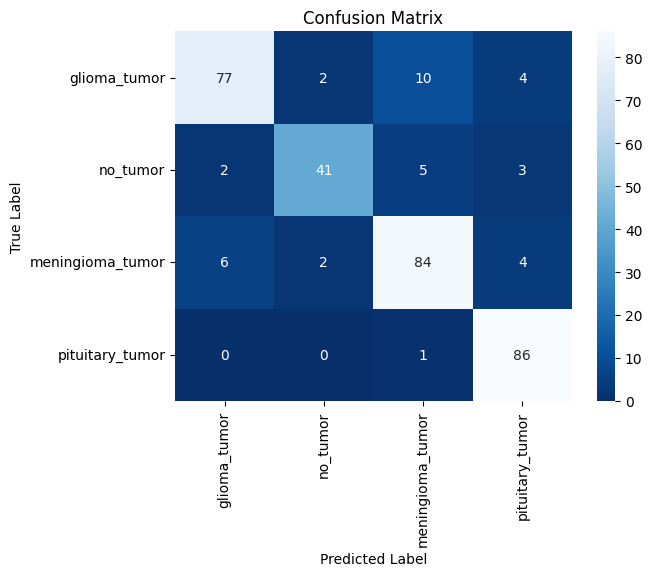

In [ ]:
Show(model)

In [ ]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.91      0.83      0.87        93
           1       0.91      0.80      0.85        51
           2       0.84      0.88      0.86        96
           3       0.89      0.99      0.93        87

    accuracy                           0.88       327
   macro avg       0.89      0.87      0.88       327
weighted avg       0.88      0.88      0.88       327



1/1 [==============================] - 0s 175ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



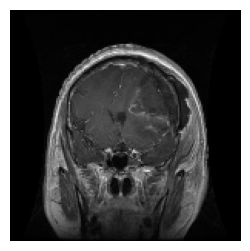

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()